In [0]:
import numpy as np
import cv2
from PIL import Image
import os
import gc

In [0]:
# Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load the Drive path where the data is loaded.
path='/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/DataSet'

In [0]:
# Extracting the data by 7zipper
!7z x '{path}'/bg.7z -o'/content/Dataset/bg'
!7z x '{path}'/fgbg.7z -o'/content/Dataset/fgbg'
!7z x '{path}'/fgbgmask.7z -o'/content/Dataset/fgbgmask/'
!7z x '{path}'/Densedepth.7z -o'/content/Dataset/dense'
!7z x '{path}'/fg.7z -o'/content/Dataset/fg'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/Colab N . ol_of_AI/TSAI/TSAI/S14/DataSet/                                                                           1 file, 2286969 bytes (2234 KiB)

Extracting archive: /content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/DataSet/bg.7z
--
Path = /content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/DataSet/bg.7z
Type = 7z
Physical Size = 2286969
Headers Size = 1341
Method = LZMA2:3m
Solid = +
Blocks = 1

  0%    Everything is Ok

Files: 100
Size:       2341905
Compressed: 2286969

7-Zip [64] 16.02 : Copyright (c

# Path Variables

In [0]:
pathbg='/content/Dataset/bg/'
pathfgbg='/content/Dataset/fgbg/'
pathfgbgmask='/content/Dataset/fgbgmask/'
pathdense='/content/Dataset/dense/'
pathfg='/content/Dataset/fg/'

# Folder Size and their Memory

In [0]:
import subprocess
def size(path):
    return subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8')

In [0]:
print('bg size:',size(pathbg))
print('fgbg size:', size(pathfgbg))
print('fgbgmask size:', size(pathfgbgmask))
print('dense size:', size(pathdense))
print('fg size', size(pathfg))
print('Total Size', size('/content/Dataset'))

bg size: 2.5M
fgbg size: 9.8G
fgbgmask size: 1.7G
dense size: 1.6G
fg size 1004K
Total Size 13G


# Mean and Std of DataSet

In [0]:
def load_images(output_shape, image_files):
    mean=0
    std=0
    if len(image_files)>=50000:
      x=0
      length=10000
      rg=int(len(image_files)/length)
      Flag=True
      for i in range(rg):
        files=image_files[x:x+length]
        loaded_images = np.array([np.asarray(Image.open( file ).resize(output_shape), dtype=float) for file in files])
        imshape=loaded_images.reshape(-1, 1) if len(loaded_images.shape)<4 else loaded_images.reshape(-1, loaded_images.shape[-1])
        del loaded_images
        gc.collect()
        if Flag:
          elements,sums,ssq, Flag = imshape.shape[0], imshape.sum(0), np.square(imshape).sum(0), False
          x=x+length
          del imshape
          gc.collect()
          continue
        elements+=imshape.shape[0]
        sums+=imshape.sum(0)
        ssq+=np.square(imshape).sum(0)
        del imshape
        gc.collect()
        x=x+length
      mean=sums/elements/255
      std=np.sqrt((ssq/elements)-np.square(sums/elements))/255
    else:
      loaded_images = []    
      for file in image_files:
          x = np.asarray(Image.open( file ).resize(output_shape), dtype=float)
          loaded_images.append(x)
      loaded_images=np.array(loaded_images)
      mean = loaded_images.reshape(-1, loaded_images.shape[-1]).mean(0)/255
      std = loaded_images.reshape(-1, loaded_images.shape[-1]).std(0)/255
    return mean, std


In [0]:
# wlaktrough
path='Dataset/'
def walk(path):
  bgs=[]
  samples=[]
  filenames=[]
  for root, dirs, files in os.walk(path):
    if root==path:
      bgs=dirs
    elif len(files)==0 and root.split('/')[-1] in bgs:
      samples = samples + dirs
    elif len(root.split('/'))==3 and root.split('/')[2] in samples:
        filenames=filenames+list(map(lambda x: os.path.join(root, x), files))
    if len(files)!=0:
      filenames=filenames+list(map(lambda x: os.path.join(root, x), files))
  return filenames

In [0]:
print('Bg Mean,std',load_images((224,224),walk(pathbg)))
print('FgBg Mask Mean,std',load_images((224,224),walk(pathfgbgmask)))

Bg Mean,std (array([0.49836101, 0.50576683, 0.48631948]), array([0.27918635, 0.27833673, 0.31944063]))
FgBg Mask Mean,std (array([0.05250582]), array([0.22033702]))


In [0]:
print('FgBg Dense Mean,std',load_images((224,224),walk(pathdense)))
print('Fg Images Mean,std',load_images((100,100),walk(pathfg)))

FgBg Dense Mean,std (array([0.41627218]), array([0.25850094]))
Fg Images Mean,std (array([0.10724495, 0.09750263, 0.09101623, 0.22677654]), array([0.22944672, 0.2064019 , 0.19510001, 0.4096344 ]))


In [0]:
print('FgBg Images Mean,std',load_images((224,224),walk(pathfgbg)))

FgBg Images Mean,std (array([0.49641467, 0.50198746, 0.48275208]), array([0.2798614 , 0.27848746, 0.31762387]))


# Display Sample Images

In [0]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np

def show_images(images, cols = 1, titles = None, figsize=(5,5)):
    #assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    #if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=figsize)
    for n, image in enumerate(images):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if len(image.getbands()) == 1:
            plt.gray()
        plt.axis("off")
        plt.imshow(image)
        plt.tight_layout()
        #a.set_title(title)
    # fig.set_size_inches(0.1*np.array(fig.get_size_inches()) * n_images)
    fig.tight_layout()
    #fig.suptitle(titles)
    plt.show()
    fig.savefig(titles+'.jpg')

def display_grid(base_path, n, col, output_shape, title,figsize=(5,5)):
  input_files = []
  #cols = int(np.sqrt(n))
  cols=col
  input_files = base_path[:n]
  image_list = list(map(lambda im: Image.open(im).resize(output_shape), input_files))
  show_images(image_list, cols=cols, figsize=figsize, titles=title)

# Sample Bg Images

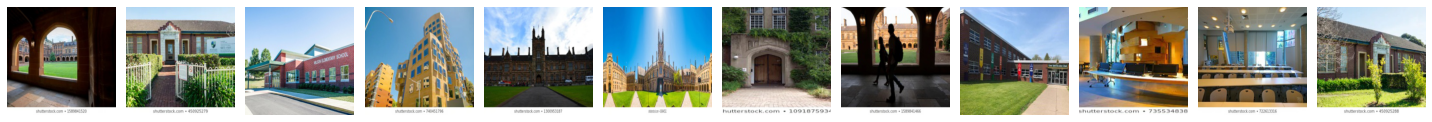

In [89]:
display_grid(walk(pathbg), 12, 1, (224, 224),  title='Sample_Bg_Images',figsize=(20,2))

# Sample Fg Images

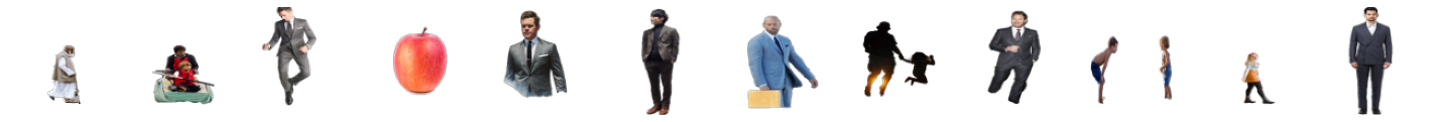

In [90]:
display_grid(walk(pathfg), 12, 1, (100, 100),  title='Sample_Fg_Images',figsize=(20,2))

# Sample FG BG Images

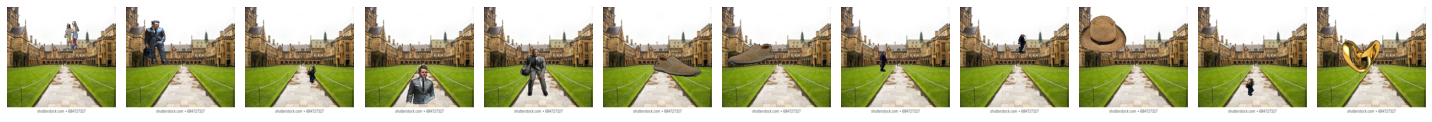

In [91]:
display_grid(walk(pathfgbg), 12, 1, (224, 224),  title='Sample_FgBg_Images',figsize=(20,2))

# Sample FG BG Mask Images

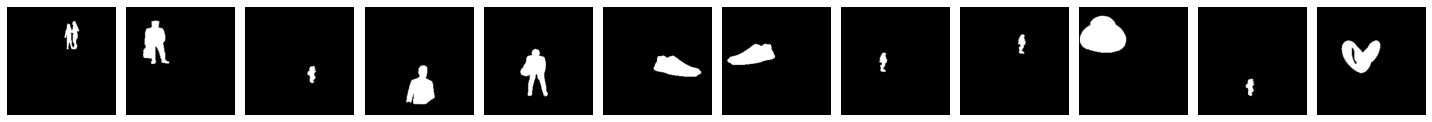

In [92]:
display_grid(walk(pathfgbgmask), 12, 1, (224, 224),  title='Sample_FgBg_Masks_Images',figsize=(20,2))

# Sample FG BG Depth Images

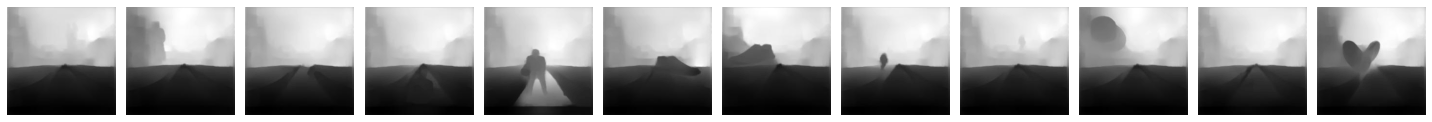

In [93]:
display_grid(walk(pathdense),  12, 1, (224, 224),  title='Sample_FgBg_Dense_Images',figsize=(20,2))

# Data Visulization with all layers

In [0]:
Images=walk(pathbg)[25:30]+walk(pathfg)[45:50]+walk(pathfgbg)[25:30]+walk(pathfgbgmask)[25:30]+walk(pathdense)[25:30]

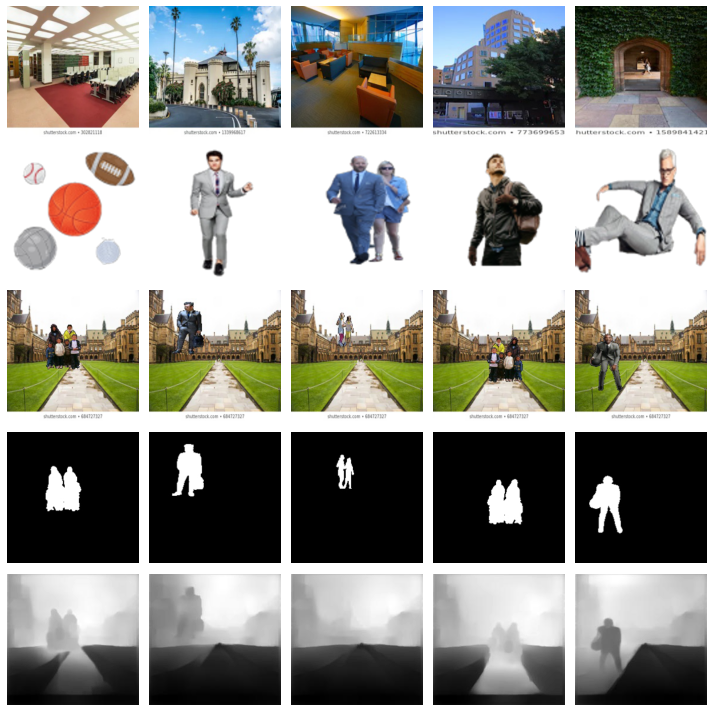

In [0]:
display_grid(Images, 25, 5, (224, 224), title='Sample_DataSet', figsize=(10,10))

In [0]:
!ls /content/*.jpg

/content/Sample_Bg_Images.jpg	       /content/Sample_FgBg_Images.jpg
/content/Sample_DataSet.jpg	       /content/Sample_FgBg_Masks_Images.jpg
/content/Sample_FgBg_Dense_Images.jpg  /content/Sample_Fg_Images.jpg


In [94]:
%cp -av /content/*.jpg '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/Save_Data/'

'/content/Sample_Bg_Images.jpg' -> '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/Save_Data/Sample_Bg_Images.jpg'
'/content/Sample_DataSet.jpg' -> '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/Save_Data/Sample_DataSet.jpg'
'/content/Sample_FgBg_Dense_Images.jpg' -> '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/Save_Data/Sample_FgBg_Dense_Images.jpg'
'/content/Sample_FgBg_Images.jpg' -> '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/Save_Data/Sample_FgBg_Images.jpg'
'/content/Sample_FgBg_Masks_Images.jpg' -> '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/Save_Data/Sample_FgBg_Masks_Images.jpg'
'/content/Sample_Fg_Images.jpg' -> '/content/drive/My Drive/Colab Notebooks/Github_Repo/The_School_of_AI/TSAI/TSAI/S14/Save_Data/Sample_Fg_Images.jpg'
